# Стратегия взаимодействия с клиентами в фитнес-центре

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами.

Наша задача — провести анализ и подготовить план действий по удержанию клиентов. Для этого нам предоcтавили данные на месяц до оттока и факт оттока на определённый месяц.

План проекта:

1. спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

2. сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

3. проанализировать основные признаки, наиболее сильно влияющие на отток;

4. сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

  1) выделить целевые группы клиентов;
  
  2) предложить меры по снижению оттока;
  
  3) определить другие особенности взаимодействия с клиентами.

<h1>Содержание<span class="tocSkip"></span></h1>


<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-и-предобработка-данных" data-toc-modified-id="Изучение-и-предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение и предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Модель-прогнозирования-оттока-клиентов" data-toc-modified-id="Модель-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общие выводы</a></span></li>

## Изучение и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#устраним красные предупреждения
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# загрузка исходных данных и вывод первых строк(развернем таблицу, чтобы видеть все признаки)
gym = pd.read_csv('datasets/gym_churn.csv')
gym.head().transpose()

,0,1,2,3,4
gender,1.000000,0.000000,0.000000,0.000000,1.000000
Near_Location,1.000000,1.000000,1.000000,1.000000,1.000000
Partner,1.000000,0.000000,1.000000,1.000000,1.000000
Promo_friends,1.000000,0.000000,0.000000,1.000000,1.000000
Phone,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,6.000000,12.000000,1.000000,12.000000,1.000000
Group_visits,1.000000,1.000000,0.000000,1.000000,0.000000
Age,29.000000,31.000000,28.000000,33.000000,26.000000
Avg_additional_charges_total,14.227470,113.202938,129.448479,62.669863,198.362265
Month_to_end_contract,5.000000,12.000000,1.000000,12.000000,1.000000


**Описание данных**

Фитнес-клуб предоставил сведения в csv-файле.

В таблице содержатся данные на месяц до оттока и факт оттока на определённый месяц:

*Данные клиента за предыдущий до проверки факта оттока месяц:*

    'gender' — пол;
    'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    'Partner' — сотрудник компании-партнёра клуба;
    Promo_friends — факт первоначальной записи в рамках акции «приведи друга» ;
    'Phone' — наличие контактного телефона;
    'Age' — возраст;
    'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
    
*Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:*

    'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    'Group_visits' — факт посещения групповых занятий;
    'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и    
    массажный салон.
    'Churn' — факт оттока в текущем месяце.

In [3]:
# для удобства переименовываем столбцы

gym = gym.rename(columns={
    'Near_Location':'near_loc',
    'Partner':'partner', 
    'Promo_friends':'promo', 
    'Phone':'phone',
    'Contract_period':'contract_period', 
    'Group_visits':'group_visits', 
    'Age':'age',
    'Avg_additional_charges_total':'avg_add_charges_total', 
    'Month_to_end_contract':'month_to_end', 
    'Lifetime':'lifetime',
    'Avg_class_frequency_total':'avg_class_total', 
    'Avg_class_frequency_current_month':'avg_class_cur_month',
    'Churn':'churn'      
})

In [4]:
# выведем общую информацию о данных
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 4000 non-null   int64  
 1   near_loc               4000 non-null   int64  
 2   partner                4000 non-null   int64  
 3   promo                  4000 non-null   int64  
 4   phone                  4000 non-null   int64  
 5   contract_period        4000 non-null   int64  
 6   group_visits           4000 non-null   int64  
 7   age                    4000 non-null   int64  
 8   avg_add_charges_total  4000 non-null   float64
 9   month_to_end           4000 non-null   float64
 10  lifetime               4000 non-null   int64  
 11  avg_class_total        4000 non-null   float64
 12  avg_class_cur_month    4000 non-null   float64
 13  churn                  4000 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [5]:
# заменим тип данных у признака "срок до окончания абонемента" на int, т.к. там только целые числа

gym['month_to_end'] = gym['month_to_end'].astype('int32')

# заменим тип данных у признаков с float64 на float32 для экономии памяти

columns_for_astype = ['avg_add_charges_total',
                     'avg_class_total',
                      'avg_class_cur_month']

for col in columns_for_astype:
    gym[col] = gym[col].astype('float32')
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 4000 non-null   int64  
 1   near_loc               4000 non-null   int64  
 2   partner                4000 non-null   int64  
 3   promo                  4000 non-null   int64  
 4   phone                  4000 non-null   int64  
 5   contract_period        4000 non-null   int64  
 6   group_visits           4000 non-null   int64  
 7   age                    4000 non-null   int64  
 8   avg_add_charges_total  4000 non-null   float32
 9   month_to_end           4000 non-null   int32  
 10  lifetime               4000 non-null   int64  
 11  avg_class_total        4000 non-null   float32
 12  avg_class_cur_month    4000 non-null   float32
 13  churn                  4000 non-null   int64  
dtypes: float32(3), int32(1), int64(10)
memory usage: 375.1 K

In [6]:
# Выведем процент пропусков
round((gym.isna().mean()*100),2)

gender                   0.0
near_loc                 0.0
partner                  0.0
promo                    0.0
phone                    0.0
contract_period          0.0
group_visits             0.0
age                      0.0
avg_add_charges_total    0.0
month_to_end             0.0
lifetime                 0.0
avg_class_total          0.0
avg_class_cur_month      0.0
churn                    0.0
dtype: float64

In [7]:
#Проверим наличие дубликатов 
print('Обнаружено дубликатов:', gym.duplicated().sum())

Обнаружено дубликатов: 0


**Вывод**

На этапе предобработки данных мы изучили данные из файлов, привели названия столбцов таблиц к одному стилю, заменили тип данных, где это необходимо.
Пропусков в данных не обнаружено, строковые значения признаков уже преобразованы в числовые до нас.

## Исследовательский анализ данных (EDA)

**Изучение признаков, средних значений и стандартных отклонений**

In [8]:
# выведем статистику по признакам
gym.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_loc,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_add_charges_total,4000.0,146.943649,96.355606,0.148205,68.868832,136.220161,210.949619,552.590759
month_to_end,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


В целом, данные равномерные, стандартные отклонения не велики. Возможно будут выбросы для признака 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра. Интересные данные в Лайфтайм: при среднем сроке 4 мес, есть клиенты, которые занимаются и 2.5 года. 

Посмотрим данные подробнее.

**Средние значения признаков в двух группах, разделенных по факту оттока**

In [9]:
gym_clients = (
    gym.groupby(['churn']) #группируем по факту оттока
    .mean()
)

In [10]:
gym_clients.transpose()

churn,0,1
gender,0.510037,0.510839
near_loc,0.873086,0.768143
partner,0.534195,0.355325
promo,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_add_charges_total,158.445709,115.082901
month_to_end,5.283089,1.662582


Для клиенты, которые уходят, характерно:

- гораздо меньшая частота посещения (1 раз в неделю), 

- они более молодые (средний возраст 27 против 30 лет), 

- они почти в два раза реже занимаются в группах, 

- занимаются недавно - в среднем 1 месяц,

- имеют более короткие абонементы (1,7 мес. против 5,7 мес.). 

Наличие контактного телефона, близость локации на отток не влияют.

**Столбчатые гистограммы и распределения признаков**

In [11]:
# разделим на группы по оттоку
lost_clients = gym[gym['churn']==1]
left_clients = gym[gym['churn']==0]

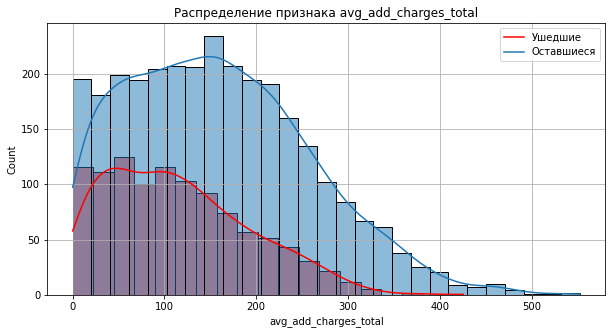

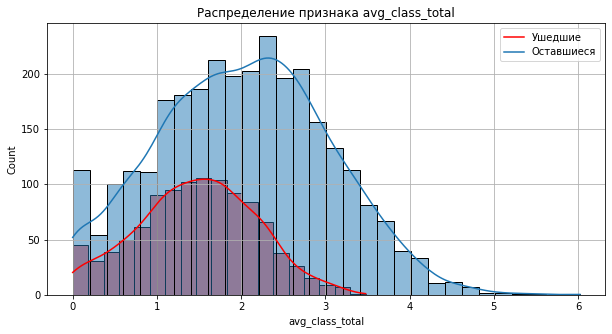

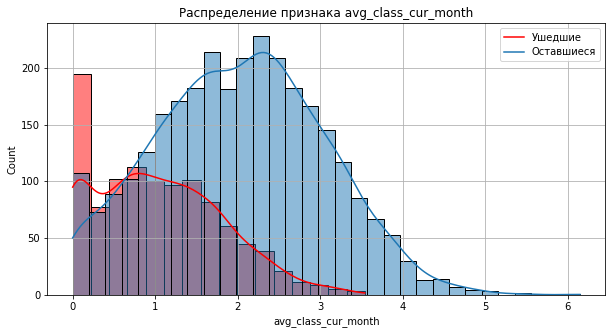

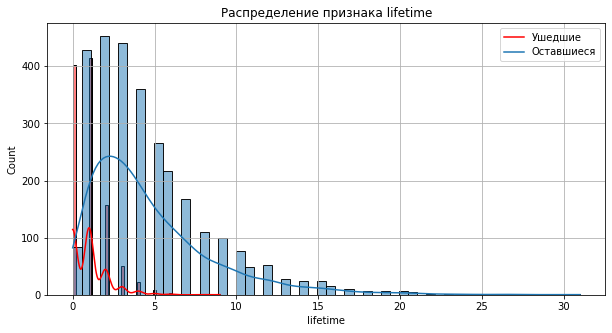

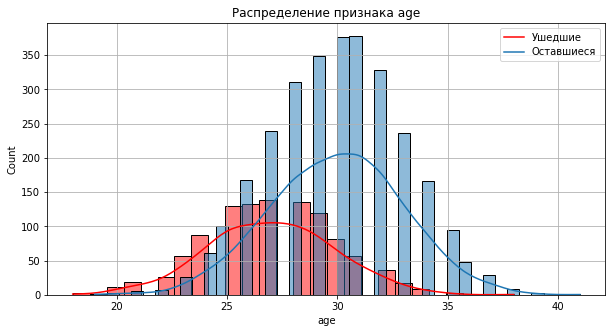

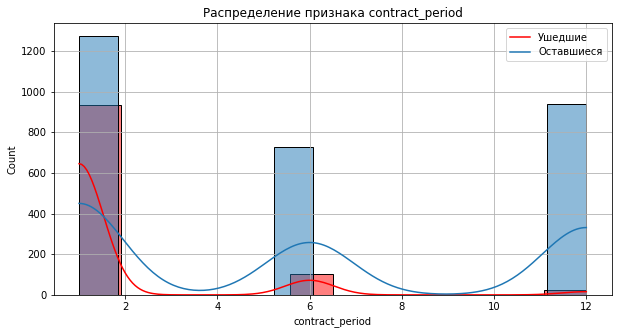

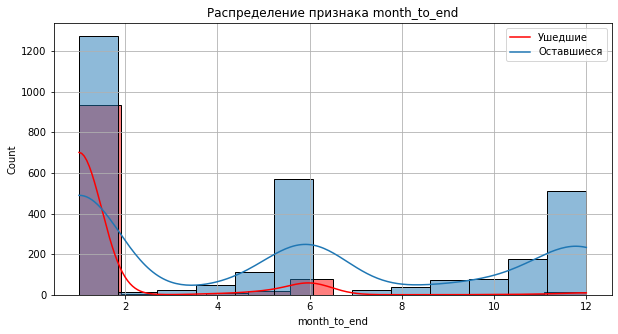

In [12]:
# Построим гистограммы для числовых признаков

hist_columns = ['avg_add_charges_total', 
                    'avg_class_total', 
                    'avg_class_cur_month', 
                    'lifetime', 
                    'age', 
                    'contract_period', 
                    'month_to_end']


for col in hist_columns:
    fig, ax = plt.subplots(figsize=(10, 5)) 
    plt.title('Распределение признака '+ col)
    sns.histplot(lost_clients[col], color="r", kde=True)
    sns.histplot(left_clients[col], kde=True)
    plt.legend(['Ушедшие', 'Оставшиеся'])
    plt.grid()
    plt.show()

Распределение средней выручки от других услуг фитнес-центра для обоих групп клиентов смещено влево, приэтом те, кто остаются, тратят больше на доп.услуги.

Распределение средней частоты посещений в неделю за всё время действия абонемента в обоих группах является нормальным. Для лояльной группы оно немного смещено влево, а для группы уходящих в отток имеется сильное смещение влево. Аналогичные различия между группами наблюдаются и для распределений средней частоты посещений в неделю за месяц. Стоит также обратить внимание, на большое число клиентов, которые вообще не посещали фитнес-центр в предыдущем месяце среди тех, кто ушёл. 

Распределение времени с момента первого обращения в фитнес-центр для обоих групп сильно смещено влево,но для оставшихся клиентов принимает более высокие значения, т.е. это постоянные клиенты.

По возрасту обе группы имеют нормальное распределение, но распределение возраста оставшихся клиентов немного смещёно вправо, а  ушедших клиентов - влево, что подтверждает вывод о том, что уходят более молодые клиенты.

Распределение длительности действующего абонемента по группам различается. Среди ушедших клиентов наиболее популярны абонементы сроком на 1 месяц, как и для оставшихся клиентов, но в отличии от оставшихся среди них очень мало долгосрочны абонементов: на 6 месяцев оформляют абонементы очень малое число клиентов и практически нет абонементов на 12 месяцев. Различия в распределении групп по сроку до окончания действующего абонемента такие же, как и в распределениях по длительности абонемента.


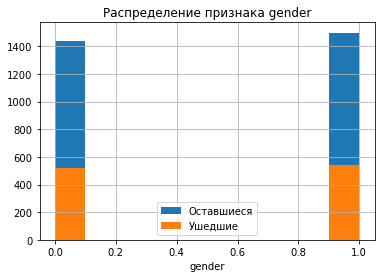

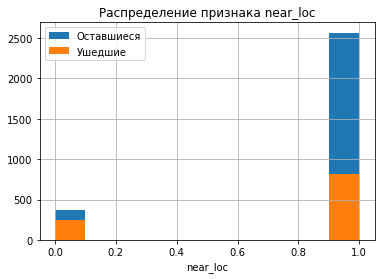

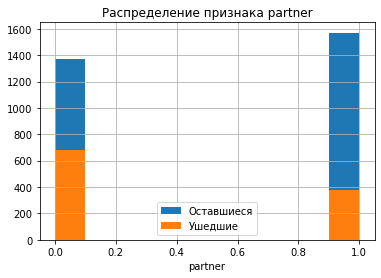

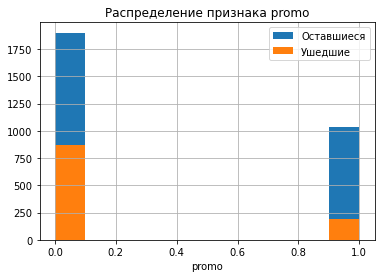

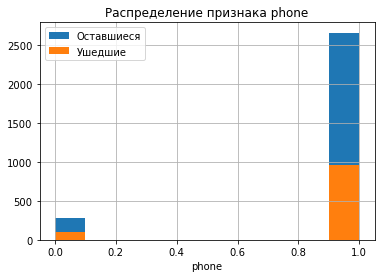

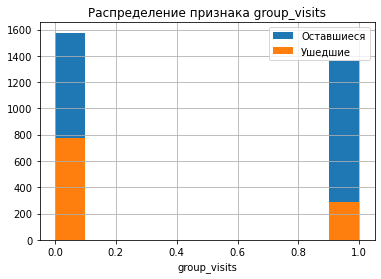

In [13]:
# Построим столбчатые гистограммы для категориальных признаков

for col in gym.drop('churn', axis = 1).columns:
    if col not in hist_columns:
        plt.title('Распределение признака '+ col)
        plt.xlabel(col)
        gym.groupby('churn')[col].hist()
        plt.legend(['Оставшиеся', 'Ушедшие'])
        plt.show()

По полу, близости к фитнес-центру, наличию контактного телефона обе группы имеют схожее равномерное распределение.

Есть различия в распределении групп между теми, кто является сотрудником компании-партнёра клуба и не является. В группе лояльных клиентов число имеющих отношение к компании-партнёра сотрудников явно больше, чем среди тех, кто уходит. Различия в распределении групп по посещению групповых занятий такие же, как и в распределениях по принадлежности к компании-партнёру.

Среди тех, кто остался, по промо-акции "Приведи друга" клиентов немного больше, но распределения схожи.

In [14]:
cm = gym.corr() #вычисляем матрицу корреляций


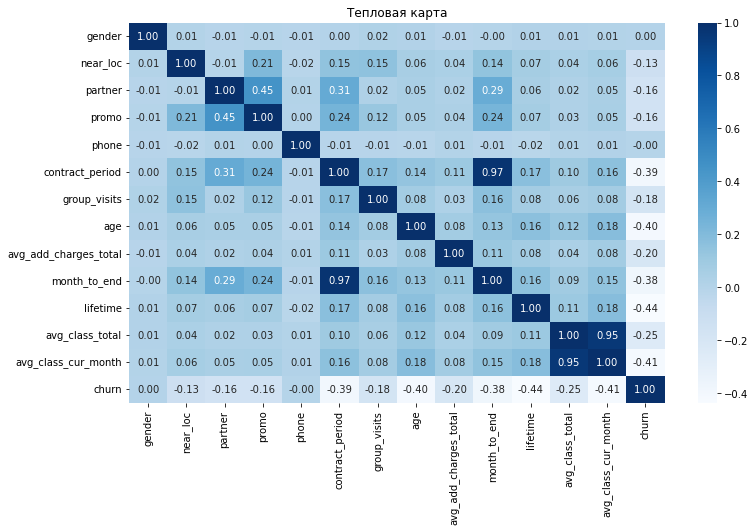

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True, fmt='0.2f', cmap="Blues")
plt.title('Тепловая карта')
plt.show()


Тепловая карта показала, что на отток влияют:

-  длительность текущего действующего абонемента (в месяцах),
-  возраст клиентов,
- срок до окончания текущего действующего абонемента (в месяцах),
- время с момента первого обращения в фитнес-центр (в месяцах),
- средняя частота посещений в неделю за предыдущий месяц.

Чем больше данные признаки, тем меньше отток.

**Вывод**

Исследовательский анализ позволил выявить характерные оособенности клиентов, склонных к оттоку:

1. молодые люди в возрасте 25-30 лет;
2. те, кто занимается в фитнес-центре недавно - в среднем  месяц,
3. реже посещают фитнес-центр - в среднем 1 раз в неделю,
4. почти в 2 раза реже занимаются на групповых занятиях,
5. имеют более короткие абонементы (очень редко более 6 месяцев),
6. тратят меньше на доп.услуги фитнес-центра: кафе, спорттовары, косметический и массажный салон.


Также были выделены признаки, которые имеют наибольшее влияние на отток и которые могут быть наиболее ценными для модели исходя из корреляций. Это признаки:

1. длительность текущего действующего абонемента (в месяцах),
2. возраст клиентов,
3. срок до окончания текущего действующего абонемента (в месяцах),
4. время с момента первого обращения в фитнес-центр (в месяцах),
5. средняя частота посещений в неделю за предыдущий месяц.

На тепловой карте ещё можно выделить и сильно скоррелированные признаки (коэффициент корреляции больше 0,8):
1. длительность абонемента и срок до окончания действия абонемента клиентов,
2. средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц.

В таком случае оставим только признаки, корреляция между которыми не превышает порога 0,8, иначе с нашей моделью линейной регресии могут возникнуть проблемы, а именно: нерепрезентативные веса и переобученная под эти признаки модель. 


In [16]:
gym = gym.drop(columns = ['month_to_end', 'avg_class_cur_month'],axis = 1)   

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

**Разделим данные на обучающую и валидационную выборку**

In [17]:
#Разделим данные на признаки (матрица x) и целевую переменную (y)
x = gym.drop('churn', axis = 1)
y = gym['churn']

#Разделим выборку на обучающую 80% и валидационную 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

#Cтандартизируем данные
scaler = StandardScaler()
scaler.fit(x_train)

x_train_st = scaler.transform(x_train)
x_test_st = scaler.transform(x_test)

**Обучение моделей "Логистическая регрессия" и "Случайный лес"**

**Построим модель способом "Логистическая регрессия"**

In [18]:
#Зададим алгоритм для модели
logreg_model = LogisticRegression(random_state=0)

#Обучим модель
logreg_model.fit(x_train, y_train)

#Воспользуемся обученной моделью, чтобы сделать прогнозы
logreg_predictions = logreg_model.predict(x_test)
logreg_probabilities = logreg_model.predict_proba(x_test)[:,1]

**Построим модель способом "Случайный лес"**

In [19]:
#Зададим алгоритм для модели
randfor_model = RandomForestClassifier(random_state=0)

#Обучим модель
randfor_model.fit(x_train, y_train)

#Воспользуемся обученной моделью, чтобы сделать прогнозы
randfor_predictions = randfor_model.predict(x_test)
randfor_probabilities = randfor_model.predict_proba(x_test)[:,1]

**Cравнение моделей "Логистическая регрессия" и "Случайный лес"**

In [20]:
#Напишем функцию для вывода метрики
def print_metrics(y_true, y_pred, y_proba, model_name):
    print("Метрики для модели "+model_name)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('F1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [21]:
#Вывод метрик для модели Логистическая регрессия
print_metrics(y_test, logreg_predictions, logreg_probabilities, 'Логистическая регрессия')
print()
#Вывод метрик для модели случайного леса
print_metrics(y_test, randfor_predictions, randfor_probabilities, 'Случайный лес')

Метрики для модели Логистическая регрессия
Accuracy: 0.88
Precision: 0.79
Recall: 0.76
F1: 0.77
ROC_AUC: 0.94

Метрики для модели Случайный лес
Accuracy: 0.89
Precision: 0.81
Recall: 0.79
F1: 0.80
ROC_AUC: 0.95


**Вывод**

Мы разделили данные на обучащую и валидационную выборку стандартно в соотношении 80:20 и стандартизировали данные.
Затем построили и обучили 2 модели: методом логистической регрессии и случайного леса.

Стоит отменить, что у обеих моделей хорошие показатели метрик, и каждую из них можно было бы использовать для прогноза.
Но всё же модель методом случайный лес показывает себя лучше по метрикам:

Accuracy (доля правильных ответов в пределах класса) - 0.89

Precision (точность прогнозирования) - 0.81

Recall (полнота) - 0.79

F1 (сводная метрика) - 0.80

ROC_AUC (оценка качества классификатора) - 0.95

## Кластеризация клиентов

**Стандартизация данных**

In [22]:
scaler = StandardScaler()
x_st = scaler.fit_transform(x)

**Матрица расстояний и дендрограмма**

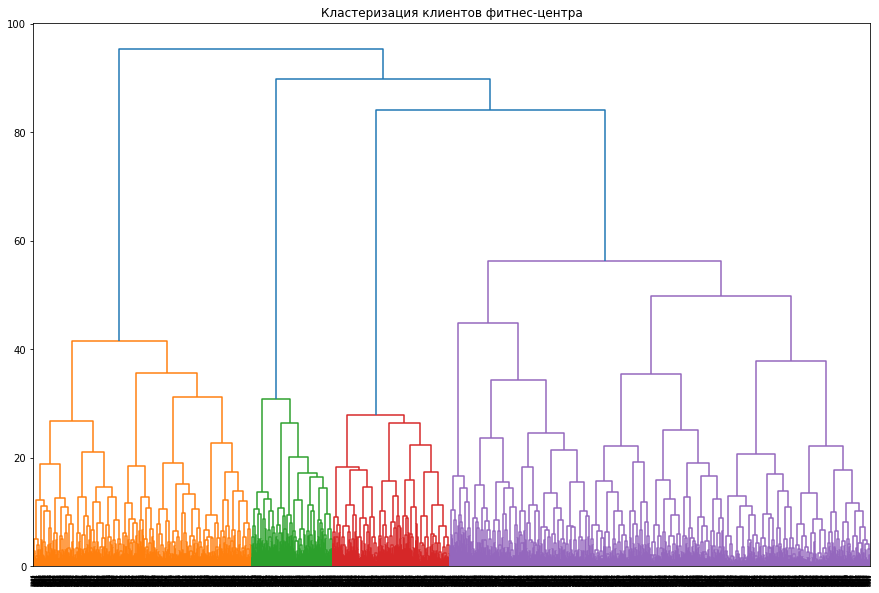

In [23]:
#Сохраним матрицу расстояний
links = linkage(x_st, method = 'ward')

#Построим дендрограмму
plt.figure(figsize=(15, 10))
plt.title('Кластеризация клиентов фитнес-центра')
dendrogram(links, orientation='top')
plt.show()

Согласно дендрограмме оптимально создание 4 кластеров, но 1 из них потенциально можно разделить еще на несколько.

**Кластеризации по алгоритму K-Means и прогнозирование кластеров клиентов**

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.
Согласно условиям проекта, за число кластеров принимаем n=5.

In [24]:
km = KMeans(n_clusters = 5, random_state = 0) #Задаём число кластеров, равное 5
labels = km.fit_predict(x_st) #Применяем алгоритм K-Means к данным и формируем вектор кластеров
gym['cluster'] = labels #Добавим столбец с номерами кластеров в исходный датафрейм
gym.head().transpose()

,0,1,2,3,4
gender,1.000000,0.000000,0.000000,0.000000,1.000000
near_loc,1.000000,1.000000,1.000000,1.000000,1.000000
partner,1.000000,0.000000,1.000000,1.000000,1.000000
promo,1.000000,0.000000,0.000000,1.000000,1.000000
phone,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,6.000000,12.000000,1.000000,12.000000,1.000000
group_visits,1.000000,1.000000,0.000000,1.000000,0.000000
age,29.000000,31.000000,28.000000,33.000000,26.000000
avg_add_charges_total,14.227470,113.202934,129.448486,62.669865,198.362259
lifetime,3.000000,7.000000,2.000000,2.000000,3.000000


In [25]:
#Выведем средние значения признаков для кластеров
gym.groupby('cluster').mean().transpose()

cluster,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_loc,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_add_charges_total,137.540009,155.861435,143.383987,148.088898,144.208176
lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


Более всего склонны к оттоку клиенты кластеров №0 и №2. Рассмотрим распределение признаков клиентов по кластерам подробнее.

In [26]:
#Посмотрим на численность кластеров
gym.cluster.value_counts()

2    1132
1    1050
3     871
0     561
4     386
Name: cluster, dtype: int64

Видим, что кластер №2 ещё и самый крупный, значит нужно уделить ему особое внимание.

**Распределения признаков для кластеров**

Для анализа распределения признаков кластеров построим:

- столбчатые диаграммы для бинарных значений признаков,
- боксплоты для непрерывных переменных.

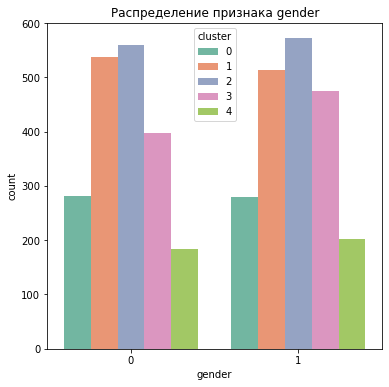

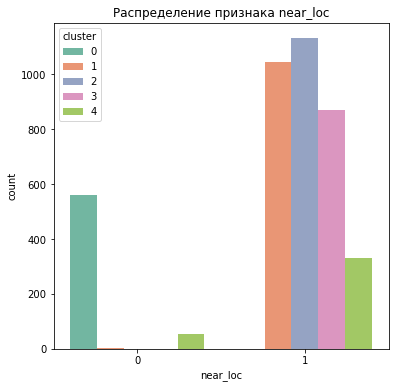

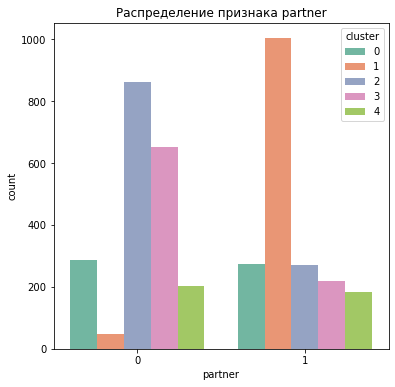

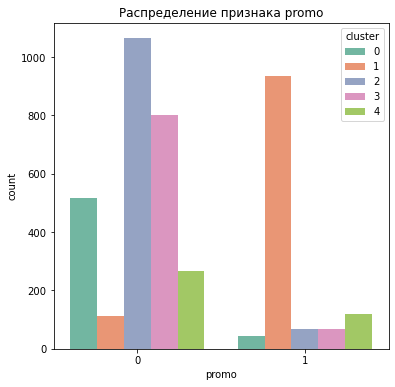

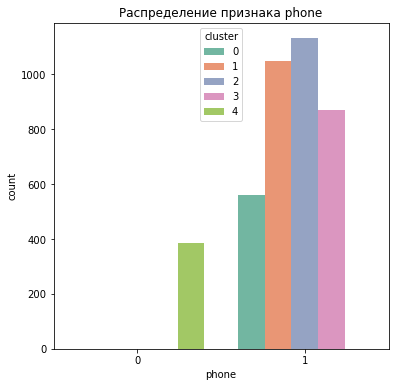

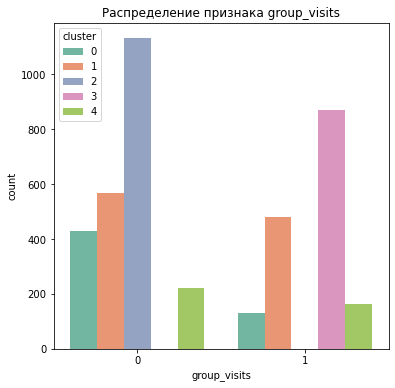

In [27]:
#Построим countplot-графики для бинарных признаков
countpot_columns = ['gender', 
                    'near_loc', 
                    'partner', 
                    'promo', 
                    'phone', 
                    'group_visits']

for col in countpot_columns:
    plt.figure(figsize=(6, 6))
    plt.title('Распределение признака '+ col)
    plt.xlabel(col)
    sns.countplot(x = gym[col], hue='cluster', data=gym, palette="Set2")
    plt.show()

- Кластеры практически одинаково распределены по полу;
- По близости от фитнес-центра больше всего выделяется кластер №2, а дальше всего находятся клиенты кластера №0.
- В кластер №1 входят больше всего сотрудников компаний-партнёров клуба. А в кластер №2 наоборот - очень мало.
- Клиентов, привлеченных с помощью акции "приведи друга" больше всего в кластере №1.
- Клиенты всех кластеров, кроме №4 оставляют свои контакты.
- Групповые занятия меньше всего посещают клиенты кластера №2, а больше всего - клиенты кластера №3.


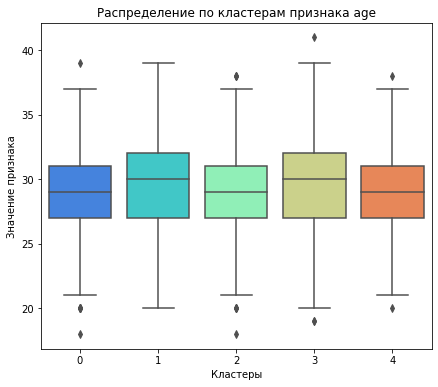

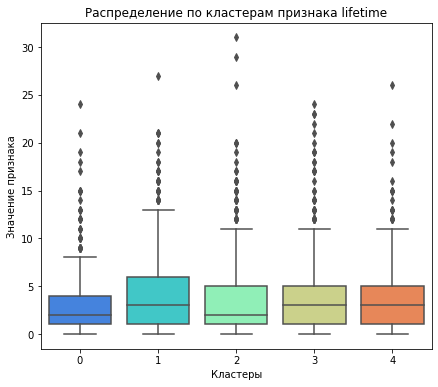

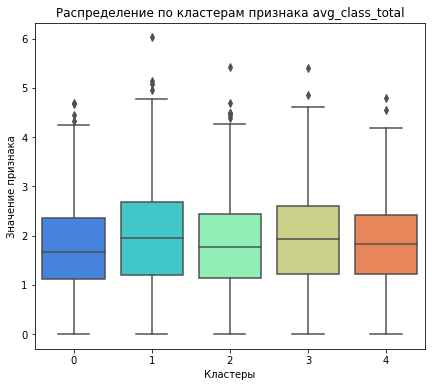

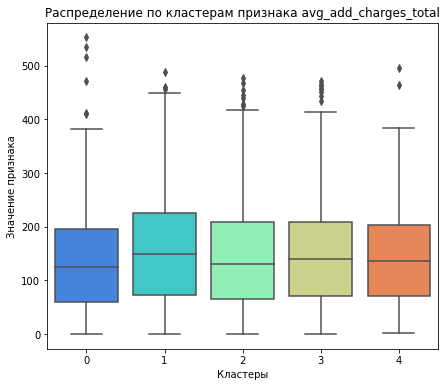

In [28]:
#Построим графики для непрерывных переменных
boxplot_columns = ['age', 
                   'lifetime',
                   'avg_class_total',
                   'avg_add_charges_total']

for col in boxplot_columns:
    plt.figure(figsize=(7, 6))
    plt.title("Распределение по кластерам признака "+col)
    sns.boxplot(x='cluster',y=col, data=gym, palette="rainbow")
    plt.xlabel('Кластеры')
    plt.ylabel('Значение признака')
    plt.show()


- Средний возраст клиентов разных кластеров примерно одинаковый, но чуть выше в кластерах №1 и №3. 
- Дольше всего в фитнес-центре занимаются клиенты кластера №1,№3 и №4, а клиенты кластера №0 и №2 меньше всех.
- За всё время действия абонемента в среднем в зал чаще ходят клиенты кластера №1 и №3 (почти 3 раза в неделю, и даже есть те, кто ходит и 6 раз в неделю), реже всего в кластере №0. За предыдущий месяц ситуация идентичная.
- Наибольшую выручку за доп.услуги фитнес-центра в среднем приносит кластер №1, а меньше всех- кластер №0

Выделим отдельно характерные особенности клиентов кластеров №0 и №2, которые более склонны к оттоку:
- Клиенты более молодые.
- Среди клиентов данных кластеров больше всего тех, кто занимается в фитнес-центре недавно.
- Клиенты  данных кластеров посещают фитнес-центр реже всех в неделю.
- Клиенты кластера №2 живут или работают близко от фитнес-центра, а клиенты кластера №0 - наборот дальше всех.
- В кластер №2 входит очень мало сотрудников компаний-партнеров в отличии от других кластеров, в кластер №0 - не больше и не меньше, чем в других кластерах.
- Среди клиентов кластеров №0 и №2 немного привлеченных с помощью акции "приведи друга".
- Клиенты кластеров №0 и №2 оставляют свои контакты.
- Клиенты кластера №2 посещают групповые занятия меньше других, а клиенты кластера №0 - не больше и не меньше, чем в других кластерах.

**Доли оттока в кластерах**

Для каждого полученного кластера посчитаем долю оттока.

In [29]:
print('Доля ушедших клиентов в {} \n'.format(gym.groupby('cluster')['churn'].mean()))

#Так как количество клиентов в кластерах неодинаковое, то нужно смотреть распределение оттока относительно всех клиентов
print('Доля ушедших клиентов, приходяшихся на {} '.format(gym.groupby('cluster')['churn'].sum()/gym['churn'].sum()))

Доля ушедших клиентов в cluster
0    0.399287
1    0.120952
2    0.381625
3    0.200918
4    0.266839
Name: churn, dtype: float64 

Доля ушедших клиентов, приходяшихся на cluster
0    0.211122
1    0.119698
2    0.407163
3    0.164939
4    0.097078
Name: churn, dtype: float64 


Самый большой отток клиентов идет по кластеру №0 - 39.9% и по кластеру №2 - 38,2%.

Самые лояльные клиенты из кластера №1, и №4 тут отток 9-12%, что подтверждает ранее полученные выводы.

**Вывод**

Кластеризация позволила определить 5 групп с характерными особенностями признаков и проанализировать показатели оттока по каждой. 

Самый большой отток клиентов был выявлен среди клиентов кластера №0 и №2.

Для них характерно:

- Клиенты более молодые.
- Среди клиентов данных кластеров больше всего тех, кто занимается в фитнес-центре недавно.
- Клиенты  данных кластеров посещают фитнес-центр реже всех в неделю.
- Клиенты кластера №2 живут или работают близко от фитнес-центра, а клиенты кластера №0 - наборот дальше всех.
- В кластер №2 входит очень мало сотрудников компаний-партнеров в отличии от других кластеров, в кластер №0 - не больше и не меньше, чем в других кластерах.
- Среди клиентов кластеров №0 и №2 немного привлеченных с помощью акции "приведи друга".
- Клиенты кластеров №0 и №2 оставляют свои контакты.
- Клиенты кластера №2 посещают групповые занятия меньше других, а клиенты кластера №0 - не больше и не меньше, чем в других кластерах.

Самые лояльные клиенты из кластера №1, тут отток чуть меньше 12%.

## Общие выводы

В проектной работе был проведен анализ для подготовки стратегии по удержанию клиентов.

В предоставленных данных пропущенных значений нет, а строковые значения признаков уже преобразованы в числовые до нас. Поэтому на этапе предобработки данных мы только привели названия столбцов таблиц к одному стилю и заменили тип данных для экономии памяти.

Исследовательский анализ позволил выявить характерные оособенности клиентов, склонных к оттоку:

1. молодые люди в возрасте 25-30 лет;
2. те, кто занимается в фитнес-центре недавно - в среднем месяц,
3. реже посещают фитнес-центр - в среднем 1 раз в неделю,
4. почти в 2 раза реже занимаются на групповых занятиях,
5. имеют более короткие абонементы (очень редко более 6 месяцев),
6. тратят меньше на доп.услуги фитнес-центра: кафе, спорттовары, косметический и массажный салон.

Также были выделены признаки, которые имеют наибольшее влияние на отток:

1. длительность текущего действующего абонемента (в месяцах),
2. возраст клиентов,
3. срок до окончания текущего действующего абонемента (в месяцах),
4. время с момента первого обращения в фитнес-центр (в месяцах),
5. средняя частота посещений в неделю за предыдущий месяц.

С помощью матрицы корреляции ещё были выявлены и сильно скоррелированные признаки (коэффициент корреляции больше 0,8):
1. длительность абонемента и срок до окончания действия абонемента клиентов,
2. средняя частота посещений в неделю за все время с начала действия абонемента и средняя частота посещений в неделю за предыдущий месяц.

Было принято решение удалить сильно скоррелированные признаки, чтобы не возникло проблем при построении модели прогнозирования.

Далее были построены модели прогнозирования оттока клиентов способами "Логистическая регрессия" и "Случайный лес", обе из которых показали хорошие результаты и могут использоваться в дальнейшей аналитической работе фитнес-центра. Но всё же модель методом случайный лес показывает себя лучше по  метрикам: Accuracy, Precision, Recall, F1 и ROC_AUC.

В рамках проекта также была обучена модель кластеризации на основании алгоритма K-Means и спрогнозированы кластеры клиентов. 
В итоге были определены 5 кластеров с характерными особенностями признаков. 

Самый большой отток клиентов был выявлен среди клиентов кластера №0 и №2. Самые лояльные клиенты из кластера №1, тут отток чуть меньше 12%.


Следовательно, для удержания клиентов фитнес-центра рекомендуем:

1. новых клиентов центра в первое время уделить особое внимание. Например, предлагать первое бесплатное занятие с личным тренером, рассказывать обо всех имеющихся услугах фитнес-центра, назначить встречу и показать весь фитнес-центр и ответить на вопросы клиента.

2. продолжать участвовать в партнерских программах и промо-акциях. Они приносят много лояльных клиентов фитнес-центру.

3. привлекать клиентов, живущих и работающих поблизости с фитнес-центром. Например, проводить акции с компаниями-партнерами, расположенными рядом, или раздавать листовки в районе фитнес-центра.

4. стимулировать клиентов к покупке абонемента сроком пользования 6 месяцев и более. 

5. проанализировать услуги фитнес-центра и уточнить, что можно улучшить для того, чтобы удержать более молодых клиентов, которые более склонны к оттоку. Например, устроить занятия по более современным направлениям.
